In [ ]:
# 딥 러닝을 이용한 자연어 처리 입문 / 10. RNN을 이용한 텍스트 분류
# 10-07 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)
# https://wikidocs.net/94600 참고

In [18]:
# bash 셸로 명령어 입력하여 라이브러리 설치하기
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,406 kB]
Fetched 2,424 kB in 3s (819 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state inf

In [19]:
# JAVA_HOME 환경변수 설정하기
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [20]:
# okt 사용해보기 from konlpy

from konlpy.tag import Okt
okt=Okt()

# 형태소
print("okt.morphs : ", okt.morphs('안녕하세요. 저는 딥러닝 입니다.'))

# 명사
print("okt.nouns : ", okt.nouns('안녕하세요. 저는 딥러닝 입니다.'))

# 형태소 + 품사
print("okt.pos : ", okt.pos('안녕하세요. 저는 딥러닝 입니다.'))

okt.morphs :  ['안녕하세요', '.', '저', '는', '딥', '러닝', '입니다', '.']
okt.nouns :  ['저', '딥', '러닝']
okt.pos :  [('안녕하세요', 'Adjective'), ('.', 'Punctuation'), ('저', 'Noun'), ('는', 'Josa'), ('딥', 'Noun'), ('러닝', 'Noun'), ('입니다', 'Adjective'), ('.', 'Punctuation')]


In [21]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 링크로부터 전체 데이터에 해당하는 ratings_total.txt 다운

In [22]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",
                           filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f39717ecdc0>)

In [ ]:
# 해당 데이터에 'ratings'와 'reviews'를 추가

In [23]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 200000


In [ ]:
# 20만 개의 샘플 중 상위 10개의 샘플 출력

In [24]:
total_data[:50]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...


In [ ]:
# 평점이 4, 5인 리뷰는 레이블 1 # 평점이 1, 2인 리뷰는 레이블 0 # 레이블은 새롭게 label에 저장

In [25]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:50]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


In [ ]:
# 중복을 제외한 샘플 수 확인

In [26]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
# 중복된 샘플 제거

In [27]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
# Null 값 확인

In [28]:
print(total_data.isnull().values.any())

False


In [ ]:
# 훈련, 테스트 데이터 7:3 비율로 분리

In [29]:
train_data, test_data = train_test_split(total_data, test_size = 0.3, random_state = 123)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 139935
테스트용 리뷰의 개수 : 59973


In [ ]:
# 트레인 데이터 한글과 공백을 제외하고 모두 제거

In [30]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-30-1c9d41fd9543>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# 테스트 데이터 한글과 공백을 제외하고 모두 제거

In [31]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 59973


<ipython-input-31-c246cbc51829>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [32]:
okt = Okt()
print(okt.morphs('배송기사나, 판매하는 회사나 불친절하고 불쾌합니다. 서비스면에선 최악이네요'))

['배송', '기사', '나', ',', '판매', '하는', '회사', '나', '불친절하고', '불쾌합니다', '.', '서비스', '면', '에선', '최악', '이네', '요']


In [33]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고',
             '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [34]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item
                                                 in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item
                                                 in x if item not in stopwords])

In [ ]:
# 긍정, 부정 리뷰 단어의 빈도 수 계산 # 리스트 저장

In [35]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# 부정 리뷰 빈도수 높은 상위 10개 단어 출력

In [36]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(10))

[('너무', 12267), ('요', 11025), ('안', 10977), ('배송', 8590), ('그냥', 7864), ('잘', 7308), ('로', 5387), ('했는데', 5261), ('별로', 5173), ('못', 4765)]


In [ ]:
# 긍정 리뷰 출력

In [37]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(10))

[('잘', 14294), ('좋아요', 13397), ('배송', 11415), ('너무', 8564), ('재구매', 8033), ('구매', 6698), ('요', 6190), ('사용', 5009), ('가격', 4677), ('같아요', 4198)]


In [38]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [40]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90894
등장 빈도가 1번 이하인 희귀 단어의 수: 50542
단어 집합에서 희귀 단어의 비율: 55.60543050146324
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.9044789499695427


In [41]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 40354


In [ ]:
#  텍스트 시퀀스 -> 정수 시퀀스로 # 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [42]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [43]:
print(X_train[:2])

[[1826, 274, 2804, 1849, 178], [224, 603, 6631, 514, 188, 280, 2, 7, 911, 9260, 11, 1]]


In [44]:
print(X_test[:2])

[[4, 2196, 4343, 13, 7498, 63, 30, 400, 1], [658, 18, 4019, 2, 7, 2545]]


In [ ]:
# 샘플들의 길이 동일하게 패딩

In [45]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 12.435344981598599


In [46]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
# 최대 길이 61, 만약 55으로 패딩할 경우 확인

In [47]:
max_len = 55
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.99642691249508


In [48]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# GRU로 네이버 쇼핑 리뷰 감성 분류

In [49]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1,
                     save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc],
                    batch_size=64, validation_split=0.2)

Epoch 1/15
1750/1750 [==============================] - ETA: 0s - loss: 0.3003 - acc: 0.8829
Epoch 1: val_acc improved from -inf to 0.90456, saving model to best_model.h5
1750/1750 [==============================] - 312s 176ms/step - loss: 0.3003 - acc: 0.8829 - val_loss: 0.2584 - val_acc: 0.9046
Epoch 2/15
1750/1750 [==============================] - ETA: 0s - loss: 0.2351 - acc: 0.9156
Epoch 2: val_acc improved from 0.90456 to 0.91267, saving model to best_model.h5
1750/1750 [==============================] - 304s 173ms/step - loss: 0.2351 - acc: 0.9156 - val_loss: 0.2401 - val_acc: 0.9127
Epoch 3/15
1750/1750 [==============================] - ETA: 0s - loss: 0.2096 - acc: 0.9259
Epoch 3: val_acc improved from 0.91267 to 0.91285, saving model to best_model.h5
1750/1750 [==============================] - 317s 181ms/step - loss: 0.2096 - acc: 0.9259 - val_loss: 0.2426 - val_acc: 0.9129
Epoch 4/15
1750/1750 [==============================] - ETA: 0s - loss: 0.1907 - acc: 0.9344
Epoch 4

In [50]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1875/1875 [==============================] - 42s 22ms/step - loss: 0.2444 - acc: 0.9131

 테스트 정확도: 0.9131


In [ ]:
# 리뷰 예측

In [51]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [52]:
sentiment_predict('배송 빠르고 제품도 좋아요. 대박나세요~')

1/1 [==============================] - 1s 821ms/step
97.14% 확률로 긍정 리뷰입니다.


In [53]:
sentiment_predict('너무 불친절하네요, AS도 너무 오래 걸림. 비추비추.')

1/1 [==============================] - 0s 33ms/step
99.79% 확률로 부정 리뷰입니다.


In [54]:
sentiment_predict('강추합니다. 재주문 의사 강력함. ^-^')

1/1 [==============================] - 0s 39ms/step
97.01% 확률로 긍정 리뷰입니다.


In [55]:
sentiment_predict('다른 곳에서 사세요. 주문하다가 기분 나빠졌음')

1/1 [==============================] - 0s 42ms/step
93.22% 확률로 부정 리뷰입니다.


In [56]:
sentiment_predict('저렴한 가격에 정말 친절하심. 굿굿굿')

1/1 [==============================] - 0s 47ms/step
92.87% 확률로 긍정 리뷰입니다.


In [57]:
sentiment_predict('별로예요. ㅏㄴㅇ미ㅗㄱㅈ더ㅏㅠㄴㅁ륳냥ㄹ니아ㅓㅁ륜ㅇㅎㄱ바ㅣㅠ마뉼,ㅣ')

1/1 [==============================] - 0s 31ms/step
99.29% 확률로 부정 리뷰입니다.


In [ ]:
# 딥 러닝을 이용한 자연어 처리 입문 / 10. RNN을 이용한 텍스트 분류
# 10-07 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)
# https://wikidocs.net/94600 참고

In [ ]:
# 기사 제목 크롤링을 통한 워드클라우드 시각화하기 [완료]
# https://durian9s-coding-tree.tistory.com/19 참고

In [58]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk 
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from wordcloud import WordCloud

In [60]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum-extra.
(Reading database ... 129066 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-extra_20180306-3_all.deb ...
Unpacking fonts-nanum-extra (20180306-3) ...
Selecting previously unselected package fonts-nanum.
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-2_all.deb ...
Unpacking fonts-nanum-coding (2.5-2) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Setting up fonts-nanum-extra (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Setting up fonts-nanum-coding (2.5-2) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


In [61]:
date='20221225' 

news_url = 'https://news.naver.com/main/ranking/popularDay.nhn?date={}'.format(date)


headers = {'User-Agent' : 'Mozilla/5.0'}
req = requests.get(news_url, headers = headers)

soup = BeautifulSoup(req.text, 'html.parser')
news_titles = soup.select('.rankingnews_box > ul > li > div > a')

crowled_title = []
for i in range(len(news_titles)):
    crowled_title.append(news_titles[i].text)
    print(i+1, news_titles[i].text)

1 핀란드서 출발한 산타, 한국 상공 도착…7분 머물다 떠났다
2 '100억 남기고 사망' 가짜뉴스에…백종원 직접 공개한 근황
3 혼주 자처한 박경림·김수용…박수홍 결혼식 '찐우정' 빛났다
4 텐트 친 외국인 몰렸다…관광지 아닌데 매출 1200% 뛴 백화점
5 "남친 아파트 옷장에 죽은사람"…6일째 실종된 택시기사 나왔다
6 “체감상 절반 이상 감염”…코로나 초토화 중국, ‘해열제’ 아우성
7 싱크로율 100%라더니…‘버티는’ 이상민 ‘감싸는’ 윤 대통령
8 국힘 장제원·권은희의 세법 개정안 ‘소신 투표’…속내는 딴판
9 “남자친구 집 옷장에 주검이”…택시기사 살해 혐의 30대 체포
10 화이트아웃·영하 50도 혹한…미국 덮친 ‘크리스마스 악몽’
11 국밥에 소주 마시던 손님들, 테이블에 “우린 미성년자” 쪽지 두고 도망
12 ‘드론 강국’ 튀르키예가 일냈다, 스텔스 무인전투기 첫 비행 성공
13 비밀경찰서 지목 中식당… 리뷰엔 “춘장 없다네” “냉동 탕수육 파나”
14 [단독] 신현영, ‘재난 핫라인’ 통해 닥터카 부를 때 남편 동승은 알리지도 않았다
15 당첨금 27억… 크리스마스 이브에 로또 1등 당첨된 9명
16 "매월 70만원 5년 부으면 5천만원"…청년도약계좌 내년 6월 출시
17 '아들한테 전화했지만…' 부산 장전동 주택 화재, 80대 부부 사망
18 [더사주 오늘의 띠별 운세]<12월 25일 일요일(음력 12월3일)>
19 이재명 "'가장 낮은 곳으로' 예수님 가르침 되짚어본다"
20 '실종' 택시기사, 연고 없는 아파트 옷장서 숨진 채 발견…경찰, 용의자 검거
21 "예약없인 못먹어요"…日 크리스마스 전통음식된 KFC
22 '헤어질 결심' 오바마 전 대통령도 인정한 올해의 영화
23 수입차 사면 세무조사가 엊그제 같은데…35년만 300만대 넘었다
24 한파뚫고 선물 60억개 전달한 산타…한국 머문 시간은
25 '크리스마스의 악몽' 호텔 예식장 바닥이 '쩍'
26 신기루였나…'돈나무 언니' 2년만에 64조원 날렸다
27 "무섭다" 백신 꺼리더니…

In [62]:
title = "".join(crowled_title)

filtered_title = title.replace('.', ' ').replace('"',' ').replace(',',' ').replace("'"," ").replace('·', ' ').replace('=',' ').replace('\n',' ')

filtered_title

'핀란드서 출발한 산타  한국 상공 도착…7분 머물다 떠났다 100억 남기고 사망  가짜뉴스에…백종원 직접 공개한 근황혼주 자처한 박경림 김수용…박수홍 결혼식  찐우정  빛났다텐트 친 외국인 몰렸다…관광지 아닌데 매출 1200% 뛴 백화점 남친 아파트 옷장에 죽은사람 …6일째 실종된 택시기사 나왔다“체감상 절반 이상 감염”…코로나 초토화 중국  ‘해열제’ 아우성싱크로율 100%라더니…‘버티는’ 이상민 ‘감싸는’ 윤 대통령국힘 장제원 권은희의 세법 개정안 ‘소신 투표’…속내는 딴판“남자친구 집 옷장에 주검이”…택시기사 살해 혐의 30대 체포화이트아웃 영하 50도 혹한…미국 덮친 ‘크리스마스 악몽’국밥에 소주 마시던 손님들  테이블에 “우린 미성년자” 쪽지 두고 도망‘드론 강국’ 튀르키예가 일냈다  스텔스 무인전투기 첫 비행 성공비밀경찰서 지목 中식당… 리뷰엔 “춘장 없다네” “냉동 탕수육 파나”[단독] 신현영  ‘재난 핫라인’ 통해 닥터카 부를 때 남편 동승은 알리지도 않았다당첨금 27억… 크리스마스 이브에 로또 1등 당첨된 9명 매월 70만원 5년 부으면 5천만원 …청년도약계좌 내년 6월 출시 아들한테 전화했지만…  부산 장전동 주택 화재  80대 부부 사망[더사주 오늘의 띠별 운세]<12월 25일 일요일(음력 12월3일)>이재명   가장 낮은 곳으로  예수님 가르침 되짚어본다  실종  택시기사  연고 없는 아파트 옷장서 숨진 채 발견…경찰  용의자 검거 예약없인 못먹어요 …日 크리스마스 전통음식된 KFC 헤어질 결심  오바마 전 대통령도 인정한 올해의 영화수입차 사면 세무조사가 엊그제 같은데…35년만 300만대 넘었다한파뚫고 선물 60억개 전달한 산타…한국 머문 시간은 크리스마스의 악몽  호텔 예식장 바닥이  쩍 신기루였나… 돈나무 언니  2년만에 64조원 날렸다 무섭다  백신 꺼리더니…2030  너도나도  부스터샷  왜? 머리카락 나왔잖아  버럭한 女손님…CCTV 보니  자기가 쓱  닭 뼈가 왜 검은색 인가요 …교촌치킨 해명에  와글 와글  주식 폭망에 부

In [63]:
tw = Twitter()

tokens_ko = tw.nouns(filtered_title)

tokens_ko

ko = nltk.Text(tokens_ko, name='기사 내 명사')

ko.tokens

ko.vocab()

new_ko=[]
for word in ko:
  if len(word) > 1 and word != '단독' and  word != ' ':
        new_ko.append(word)

new_ko

ko = nltk.Text(new_ko, name = '기사 내 명사 두 번째')

ko.tokens

ko.vocab()

data = ko.vocab().most_common(150)

data = dict(data)

/usr/local/lib/python3.9/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


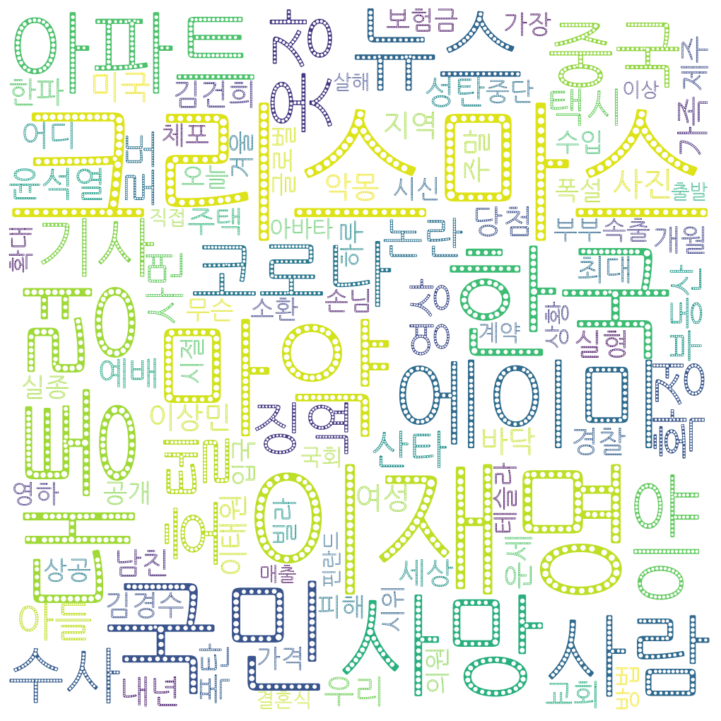

In [64]:
wordcloud = WordCloud().generate(filtered_title)

font = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'

wc = WordCloud(font_path=font,\
		background_color="white", \
		width=1000, \
		height=1000, \
		max_words=100, \
		max_font_size=300)
wc = wc.generate_from_frequencies(data)

plt.figure(figsize=(13, 13))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 기사 제목 크롤링을 통한 워드클라우드 시각화하기 [완료]
# https://durian9s-coding-tree.tistory.com/19 참고